<a href="https://colab.research.google.com/github/SebastianReimer/HAN_mulitclass_classification/blob/master/HAN_bpeEmb_multiclass_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install keras
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install nltk
!pip install numpy
!pip install bpemb

     |████████████████████████████████| 1.0MB 9.9MB/s 


In [1]:
import numpy as np 
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional, TimeDistributed, GRU, Dropout
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Layer 
from keras.optimizers import Adam
from keras.engine.input_layer import Input
from keras import backend as K
from tensorflow.keras import initializers
from sklearn.metrics import accuracy_score
import re
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download("popular")
STOPWORDS = set(stopwords.words('english'))
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

import string 
from nltk.stem import WordNetLemmatizer 

Using TensorFlow backend.


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

Source: https://humboldt-wi.github.io/blog/research/information_systems_1819/group5_han/

https://gist.github.com/kraenkem/216f8f13188c557a8b18a4b9a59dc440

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df_all = pd.read_pickle('/content/drive/My Drive/df_all_data.pickle')

In [4]:
df= df_all.sample(frac=0.05, random_state=42)
df = df.reset_index(drop=True)
print('df for developing:')
print(f"Found {df.shape[0]} texts for testing.")
print(f"Found {len(df['category'].unique())} different classes/categories for testing")


df for developing:
Found 2849 texts for testing.
Found 23 different classes/categories for testing


In [5]:


"""
Compute average number of words in each sentence and average number of sentences in each document.
"""
n_sent = 0
n_words = 0
for i in range(df.shape[0]):
    sent = nltk.tokenize.sent_tokenize(df.loc[i,'text'])
    for satz in sent:
        n_words += len(nltk.tokenize.word_tokenize(satz))
    n_sent += len(sent)
    
print("Average number of words in each sentence: ",round(n_words/n_sent))
print("Average number of sentences in each document: ", round(n_sent/df.shape[0]))



Average number of words in each sentence:  24
Average number of sentences in each document:  8


### Parameters

In [0]:


MAX_FEATURES = 200000 # maximum number of unique words that should be included in the tokenized word index
MAX_SENTENCE_NUM = 40 # maximum number of sentences in one document
MAX_WORD_NUM = 50     # maximum number of words in each sentence
EMBED_SIZE = 100     # vector size of word embedding



### Data Preprocessing
Code means labelled category

In [7]:
# Clean String
def cleanString(text,stopWords):
    """
    Cleans input string using set rules.
    Cleaning rules:         Every word is lemmatized and lowercased. Stopwords and non alpha-numeric words are removed.
                            Each sentence ends with a period.
    Input:   text         - string(in sentence structure)
             stopWords    - set of strings which should be removed from text
    Output:  returnString - cleaned input string
             idx_list     - list of lists, one list is equal to one sentence. In every list are the index
                            of each word as they appeared in the non cleaned sentence
                            e.g. nonCleaned = "This is a test." -> cleaned = "This test." -> cleaned_index = [[0,3]]
    """
    # Init the Wordnet Lemmatizer
    lemmatizer = WordNetLemmatizer()
    returnString = ""
    sentence_token = nltk.tokenize.sent_tokenize(text)
    idx_list = []
    for j in range(len(sentence_token)):
        single_sentence = nltk.tokenize.word_tokenize(sentence_token[j])
        sentences_filtered = [(idx,lemmatizer.lemmatize(w.lower())) for idx,w in enumerate(single_sentence) 
                              if w.lower() not in stopWords and w.isalnum()]
        idx_list.append([x[0] for x in sentences_filtered])
        word_list = [x[1] for x in sentences_filtered]
        returnString = returnString + ' '.join(word_list) + ' . '
    
    return returnString, idx_list

print(df.head())

                                                text category
0  Intraocular tissue plasminogen activator in a ...      C23
1  Effects of nonionic versus ionic contrast medi...      C14
2  Otitis media: the pathogenesis approach. Gener...      C09
3  Evaluation of the fine needle aspiration biops...      C04
4  Spontaneous termination of reentry after one c...      C14


In [8]:
"""
Cleans raw data using the cleanString() function from above.
English stopwords are used from nltk library.
Cleaned dataset is saved in 'data_cleaned' pandas dataframe.
Labels are converted to numbers,
"""
articles = []
n = df['text'].shape[0]
col_number = df.columns.get_loc('text')
stopWords = set(stopwords.words('english'))
data_cleaned = df.copy()
for i in range(n):
    temp_string,idx_string = cleanString(df.iloc[i,col_number],stopWords)
    articles.append(temp_string)
    print(str(i+1)+' of '+str(n)+" articles cleaned.",end='\r')
    
data_cleaned.loc[:,'text'] = pd.Series(articles,index=df.index)
data_cleaned.loc[:,'category'] = pd.Categorical(data_cleaned.category)
data_cleaned['Code'] = data_cleaned.category.cat.codes
categoryToCode = dict( enumerate(data_cleaned['category'].cat.categories))


print("Mapping for categories", categoryToCode)
print(data_cleaned.head())

Mapping for categories {0: 'C01', 1: 'C02', 2: 'C03', 3: 'C04', 4: 'C05', 5: 'C06', 6: 'C07', 7: 'C08', 8: 'C09', 9: 'C10', 10: 'C11', 11: 'C12', 12: 'C13', 13: 'C14', 14: 'C15', 15: 'C16', 16: 'C17', 17: 'C18', 18: 'C19', 19: 'C20', 20: 'C21', 21: 'C22', 22: 'C23'}
                                                text category  Code
0  intraocular tissue plasminogen activator rabbi...      C23    22
1  effect nonionic versus ionic contrast medium c...      C14    13
2  otitis medium pathogenesis approach . general ...      C09     8
3  evaluation fine needle aspiration biopsy preop...      C04     3
4  spontaneous termination reentry one cycle shor...      C14    13


### Tokenization for keras encoding

In [18]:

# Tokenization
# Word index

"""
Using the keras Tokenizer class a word index is built.
The most 'MAX_FEATURES' used words are tokenized to a number.
this dictionary is saved in word_index
"""
texts = []
for i in range(len(data_cleaned)):
    s = data_cleaned['text'].iloc[i]
    s = ' '.join([word.strip(string.punctuation) for word in s.split() if word.strip(string.punctuation) is not ""])
    texts.append(s)
tokenizer = Tokenizer(num_words=MAX_FEATURES,lower=True, oov_token=None)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index

def create_word_count(texts):
  """
  Counts how many times a word (str) appears in a list of texts
  
  Input: text: list of texts (str)
  Output: dict mapping counts of words
  """

print('Number of tokens: ' + str(len(word_index)))
print(word_index)

Number of tokens: 18072
{'patient': 1, 'group': 2, 'disease': 3, 'cell': 4, 'case': 5, 'le': 6, 'study': 7, 'treatment': 8, 'p': 9, 'may': 10, 'result': 11, 'infection': 12, 'two': 13, 'year': 14, 'one': 15, 'clinical': 16, 'effect': 17, 'rate': 18, 'control': 19, 'therapy': 20, 'level': 21, '1': 22, 'associated': 23, 'tumor': 24, 'child': 25, '2': 26, 'three': 27, 'blood': 28, 'significantly': 29, 'normal': 30, 'age': 31, 'increased': 32, 'mean': 33, 'significant': 34, '10': 35, 'risk': 36, 'acute': 37, '3': 38, 'month': 39, 'time': 40, 'compared': 41, 'factor': 42, 'day': 43, 'also': 44, 'syndrome': 45, 'cancer': 46, 'response': 47, 'human': 48, 'found': 49, 'treated': 50, 'serum': 51, 'change': 52, 'diagnosis': 53, 'complication': 54, 'pressure': 55, 'greater': 56, 'analysis': 57, 'chronic': 58, 'artery': 59, 'subject': 60, 'surgery': 61, 'lesion': 62, '5': 63, 'used': 64, 'rat': 65, '6': 66, 'without': 67, 'finding': 68, 'antibody': 69, 'use': 70, 'data': 71, 'n': 72, 'carcinoma': 

In [10]:
print(df.text[0] )
print(cleanString(df.text[0], STOPWORDS))

Intraocular tissue plasminogen activator in a rabbit model of traumatic hyphema.
 Tissue plasminogen activator was used to evaluate the clearance of traumatic hyphema in a rabbit model.
 A neodymium-YAG laser was used to disrupt iris vessels, creating a traumatic hyphema.
 Tissue plasminogen activator (1800 IU/0.1 mL) was injected into the anterior chamber 24 hours after creation of the hyphema.
 Two control groups (one receiving balanced salt solution and one receiving no treatment) were used for comparison.
 A multivariate analysis of covariance indicated that the greatest difference in hyphema clearance between the groups occurred at days 3, 4, and 5.
 Five days after tissue plasminogen activator treatment, the mean size of the clot remaining in the anterior chamber was 27% of that of the original hyphema.
 In control eyes, almost 60% of the original clot remained at day 5.
 Treatment of animals with tissue plasminogen activator doses of 5000 IU and 10,000 IU produced a substantial 

In [11]:
texts[0]

'intraocular tissue plasminogen activator rabbit model traumatic hyphema tissue plasminogen activator used evaluate clearance traumatic hyphema rabbit model laser used disrupt iris vessel creating traumatic hyphema tissue plasminogen activator 1800 ml injected anterior chamber 24 hour creation hyphema two control group one receiving balanced salt solution one receiving treatment used comparison multivariate analysis covariance indicated greatest difference hyphema clearance group occurred day 3 4 5 five day tissue plasminogen activator treatment mean size clot remaining anterior chamber 27 original hyphema control eye almost 60 original clot remained day 5 treatment animal tissue plasminogen activator dos 5000 iu iu produced substantial increase repeated bleeding episode rabbit model concluded although use tissue plasminogen activator rabbit model traumatic hyphema significantly improved clearance blood anterior chamber remaining clot size clinical benefit questionable'

### GloVe Embedding

In [17]:
"""
A pre-trained word to vector is used from GloVe by Pennington et. al.
Source: https://nlp.stanford.edu/projects/glove/
The data was trained on wikipedia articles. Each word is described by a 100d vector.
"""

# Load word vectors from pre-trained dataset
embeddings_index = {}
f = open(os.path.join(os.getcwd(), '/content/drive/My Drive/data/embedding_data/glove/glove.6B.100d.txt'), encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# Embedding

min_wordCount = 0
absent_words = 0
small_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
word_counts = tokenizer.word_counts
for word, i in word_index.items():
    if word_counts[word] > min_wordCount:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
        else:
            absent_words += 1
    else:
        small_words += 1
print('Total absent words are', absent_words, 'which is', "%0.2f" % (absent_words * 100 / len(word_index)),
      '% of total words')
print('Words with '+str(min_wordCount)+' or less mentions', small_words, 'which is', "%0.2f" % (small_words * 100 / len(word_index)),
      '% of total words')
print(str(len(word_index)-small_words-absent_words) + ' words to proceed.')
print("word_count keras: ",len(word_counts))
print("word_count keras structure: ",type(word_counts))

Found 400000 word vectors.
Total absent words are 4428 which is 24.50 % of total words
Words with 0 or less mentions 0 which is 0.00 % of total words
13644 words to proceed.
word_count keras:  18072
word_count keras structure:  <class 'collections.OrderedDict'>


### Tokenization for Byte-Pair Embedding
https://nlp.h-its.org/bpemb/

In [0]:
from bpemb import BPEmb
# Tokenization

# Word index
"""
Using the keras Tokenizer class a word index is built.
The most 'MAX_FEATURES' used words are tokenized to a number.
this dictionary is saved in word_index
"""

texts = []
for i in range(len(data_cleaned)):
    s = data_cleaned['text'].iloc[i]
    s = ' '.join([word.strip(string.punctuation) for word in s.split() if word.strip(string.punctuation) is not ""])
    texts.append(s)

    
bpemb_en = BPEmb(lang="en",vs=200000)    


'''    
tokenizer = Tokenizer(num_words=MAX_FEATURES,lower=True, oov_token=None)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index
print('Number of tokens: ' + str(len(word_index)))
'''

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


"    \ntokenizer = Tokenizer(num_words=MAX_FEATURES,lower=True, oov_token=None)\ntokenizer.fit_on_texts(texts)\nword_index = tokenizer.word_index\nprint('Number of tokens: ' + str(len(word_index)))\n"

In [0]:
len(bpemb_en.encode(texts[0]))
#texts[0]
#print(nltk.tokenize.sent_tokenize(data_cleaned.iloc[0]['text']))

135

In [0]:
print(df.text[0] )
print(cleanString(df.text[0], STOPWORDS))

### Byte-Pair Embedding 
https://nlp.h-its.org/bpemb/ 

In [0]:
"""
A pre-trained word to vector is used from GloVe by Pennington et. al.
Source: https://nlp.stanford.edu/projects/glove/
The data was trained on wikipedia articles. Each word is described by a 100d vector.
"""

# Load word vectors from pre-trained dataset
embeddings_index = {}
f = open(os.path.join(os.getcwd(), '/content/drive/My Drive/data/embedding_data/glove/glove.6B.100d.txt'), encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

'''
# Embedding

min_wordCount = 0
absent_words = 0
small_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
word_counts = tokenizer.word_counts
for word, i in word_index.items():
    if word_counts[word] > min_wordCount:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
        else:
            absent_words += 1
    else:
        small_words += 1
print('Total absent words are', absent_words, 'which is', "%0.2f" % (absent_words * 100 / len(word_index)),
      '% of total words')
print('Words with '+str(min_wordCount)+' or less mentions', small_words, 'which is', "%0.2f" % (small_words * 100 / len(word_index)),
      '% of total words')
print(str(len(word_index)-small_words-absent_words) + ' words to proceed.')
'''

### Split dataset


In [0]:
def split_df(dataframe, column_name, training_split, validation_split, test_split):
    """
    Splits a pandas dataframe into trainingset, validationset and testset in specified ratio.
    All sets are balanced, which means they have the same ratio for each category as the full set.
    Input:   dataframe        - Pandas Dataframe, should include a column for data and one for categories
             column_name      - Name of dataframe column which contains the categorical output values
             training_split   - from ]0,1[, default = 0.6
             validation_split - from ]0,1[, default = 0.2        
             test_split       - from ]0,1[, default = 0.2
                                Sum of all splits need to be 1
    Output:  train            - Pandas DataFrame of trainset
             validation       - Pandas DataFrame of validationset
             test             - Pandas DataFrame of testset
    """
    if training_split + validation_split + test_split != 1.0:
        raise ValueError('Split paramter sum should be 1.0')
        
    total = len(dataframe.index)
 
    train = dataframe.reset_index().groupby(column_name).apply(lambda x: x.sample(frac=training_split))\
    .reset_index(drop=True).set_index('index')
    train = train.sample(frac=1)
    temp_df = dataframe.drop(train.index)
    validation = temp_df.reset_index().groupby(column_name)\
    .apply(lambda x: x.sample(frac=validation_split/(test_split+validation_split)))\
           .reset_index(drop=True).set_index('index')
    validation = validation.sample(frac=1)
    test = temp_df.drop(validation.index)
    test = test.sample(frac=1)
    
    print('Total: ', len(dataframe))
    print('Training: ', len(train), ', Percentage: ', len(train)/len(dataframe))
    print('Validation: ', len(validation), ', Percentage: ', len(validation)/len(dataframe))
    print('Test:', len(test), ', Percentage: ', len(test)/len(dataframe))

    return train, validation, test
  
def wordToSeq(text,word_index,max_sentences,max_words,max_features):
    """
    Converts a string to a numpy matrix where each word is tokenized.
    Arrays are zero-padded to max_sentences and max_words length.
    
    Input:    text           - string of sentences
              word_index     - trained word_index
              max_sentences  - maximum number of sentences allowed per document for HAN
              max_words      - maximum number of words in each sentence for HAN
              max_features   - maximum number of unique words to be tokenized
    Output:   data           - Numpy Matrix of size [max_sentences x max_words]
    """
    sentences = nltk.tokenize.sent_tokenize(text)
    data = np.zeros((max_sentences, max_words), dtype='int32')
    for j, sent in enumerate(sentences):
        if j< max_sentences:
            wordTokens = nltk.tokenize.word_tokenize(sent.rstrip('.'))
            wordTokens = [w for w in wordTokens]
            k=0
            for _, word in enumerate(wordTokens):
                try:
                    if k<max_words and word_index[word]<max_features:
                        data[j,k] = word_index[word]
                        k=k+1
                except:
                    pass
    return data

def to_categorical(series,class_dict):
    """
    Converts category labels to vectors,
    Input:     series     - pandas Series containing numbered category labels
               class_dict - dictionary of integer to category string 
                            e.g. {0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'}
    Output:    Array      - numpy array containing categories converted to lists
                            e.g. 0:'business'      -> [1 0 0 0 0]
                                 1:'entertainment' -> [0 1 0 0 0]
                                 2:'politics'      -> [0 0 1 0 0]
                                 3:'sport'         -> [0 0 0 1 0]
                                 4:'tech'          -> [0 0 0 0 1]
    """
    n_classes = len(class_dict)
    new_dict = {}
    for key,value in class_dict.items():
        cat_list = [0] * n_classes
        cat_list[key] = 1
        new_dict[key] = cat_list
    y_cat = []
    for key,value in series.iteritems():
        y_cat.append(new_dict[value])
    return np.array(y_cat)
'''  
train, validation, test = split_df(df, 'category',0.8,0.1,0.1)
print(train.shape)
print(validation.shape)
print(test.shape)
print(train['text'][0])
'''

"  \ntrain, validation, test = split_df(df, 'category',0.8,0.1,0.1)\nprint(train.shape)\nprint(validation.shape)\nprint(test.shape)\nprint(train['text'][0])\n"

In [0]:
"""
Split Pandas Dataframe into train, validation and testset.
Convert data to keras conforming form
"""

print(categoryToCode)
train, validation, test = split_df(data_cleaned, 'Code',0.8,0.1,0.1)

#Training
paras = []
for i in range(train['text'].shape[0]):
    sequence = wordToSeq(train['text'].iloc[i],word_index,MAX_SENTENCE_NUM,MAX_WORD_NUM,MAX_FEATURES)
    paras.append(sequence)
x_train = np.array(paras)
y_train = to_categorical(train['Code'],categoryToCode)

#Validation
paras = []
for i in range(validation['text'].shape[0]):
    sequence = wordToSeq(validation['text'].iloc[i],word_index,MAX_SENTENCE_NUM,MAX_WORD_NUM,MAX_FEATURES)
    paras.append(sequence)
x_val = np.array(paras)
y_val = to_categorical(validation['Code'],categoryToCode)

#Test
paras = []
for i in range(test['text'].shape[0]):
    sequence = wordToSeq(test['text'].iloc[i],word_index,MAX_SENTENCE_NUM,MAX_WORD_NUM,MAX_FEATURES)
    paras.append(sequence)
x_test = np.array(paras)
y_test = to_categorical(test['Code'],categoryToCode)

{0: 'C01', 1: 'C02', 2: 'C03', 3: 'C04', 4: 'C05', 5: 'C06', 6: 'C07', 7: 'C08', 8: 'C09', 9: 'C10', 10: 'C11', 11: 'C12', 12: 'C13', 13: 'C14', 14: 'C15', 15: 'C16', 16: 'C17', 17: 'C18', 18: 'C19', 19: 'C20', 20: 'C21', 21: 'C22', 22: 'C23'}
Total:  56984
Training:  45588 , Percentage:  0.8000140390284992
Validation:  5697 , Percentage:  0.09997543170012635
Test: 5699 , Percentage:  0.10001052927137442


In [0]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(45588, 40, 50)
(5697, 40, 50)
(5699, 40, 50)
(45588, 23)
(5697, 23)
(5699, 23)


### Model with attention

In [0]:
class AttentionLayer(Layer):
    """
    Hierarchial Attention Layer as described by Hierarchical Attention Networks for Document Classification(2016)
    - Yang et. al.
    Source: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
    Theano backend
    """
    def __init__(self,attention_dim=100,return_coefficients=False,**kwargs):
        # Initializer 
        self.supports_masking = True
        self.return_coefficients = return_coefficients
        self.init = initializers.get('glorot_uniform') # initializes values with uniform distribution
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Builds all weights
        # W = Weight matrix, b = bias vector, u = context vector
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)),name='W')
        self.b = K.variable(self.init((self.attention_dim, )),name='b')
        self.u = K.variable(self.init((self.attention_dim, 1)),name='u')
        self.trainable_weights = [self.W, self.b, self.u]

        super(AttentionLayer, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, hit, mask=None):
        # Here, the actual calculation is done
        uit = K.bias_add(K.dot(hit, self.W),self.b)
        uit = K.tanh(uit)
        
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)
        ait = K.exp(ait)
        
        if mask is not None:
            ait *= K.cast(mask, K.floatx())

        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = hit * ait
        
        if self.return_coefficients:
            return [K.sum(weighted_input, axis=1), ait]
        else:
            return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        if self.return_coefficients:
            return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[-1], 1)]
        else:
            return input_shape[0], input_shape[-1]

In [0]:

"""
Create Keras functional model for hierarchical attention network
"""
embedding_layer = Embedding(len(word_index) + 1,EMBED_SIZE,weights=[embedding_matrix], 
                            input_length=MAX_WORD_NUM, trainable=False,name='word_embedding')

# Words level attention model
word_input = Input(shape=(MAX_WORD_NUM,), dtype='int32',name='word_input')
word_sequences = embedding_layer(word_input)
word_gru = Bidirectional(GRU(50, return_sequences=True),name='word_gru')(word_sequences)
word_dense = Dense(100, activation='relu', name='word_dense')(word_gru) 
word_att,word_coeffs = AttentionLayer(EMBED_SIZE,True,name='word_attention')(word_dense)
wordEncoder = Model(inputs = word_input,outputs = word_att)

# Sentence level attention model
sent_input = Input(shape=(MAX_SENTENCE_NUM,MAX_WORD_NUM), dtype='int32',name='sent_input')
sent_encoder = TimeDistributed(wordEncoder,name='sent_linking')(sent_input)
sent_gru = Bidirectional(GRU(50, return_sequences=True),name='sent_gru')(sent_encoder)
sent_dense = Dense(100, activation='relu', name='sent_dense')(sent_gru) 
sent_att,sent_coeffs = AttentionLayer(EMBED_SIZE,return_coefficients=True,name='sent_attention')(sent_dense)
sent_drop = Dropout(0.5,name='sent_dropout')(sent_att)
preds = Dense(23, activation='softmax',name='output')(sent_drop)

# Model compile
model = Model(sent_input, preds)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
print(wordEncoder.summary())
print(model.summary())

W0820 15:58:58.659601 139777273120640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0820 15:58:58.716330 139777273120640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0820 15:58:58.729822 139777273120640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0820 15:58:58.731232 139777273120640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0820 15:58:58.733872 139777273120640 depre

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_input (InputLayer)      (None, 50)                0         
_________________________________________________________________
word_embedding (Embedding)   (None, 50, 100)           6523900   
_________________________________________________________________
word_gru (Bidirectional)     (None, 50, 100)           45300     
_________________________________________________________________
word_dense (Dense)           (None, 50, 100)           10100     
_________________________________________________________________
word_attention (AttentionLay [(None, 100), (None, 100, 10200     
Total params: 6,589,500
Trainable params: 65,600
Non-trainable params: 6,523,900
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              P

In [0]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=7, batch_size=32)



W0820 15:59:09.737263 139777273120640 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 45588 samples, validate on 5697 samples
Epoch 1/7
45588/45588 [==============================] - 545s 12ms/step - loss: 2.2260 - acc: 0.3409 - val_loss: 1.8440 - val_acc: 0.4281
Epoch 2/7
45588/45588 [==============================] - 541s 12ms/step - loss: 1.8869 - acc: 0.4216 - val_loss: 1.7255 - val_acc: 0.4458
Epoch 3/7
45588/45588 [==============================] - 542s 12ms/step - loss: 1.7793 - acc: 0.4427 - val_loss: 1.6758 - val_acc: 0.4597
Epoch 4/7
45588/45588 [==============================] - 541s 12ms/step - loss: 1.7058 - acc: 0.4577 - val_loss: 1.6332 - val_acc: 0.4645
Epoch 5/7
45588/45588 [==============================] - 541s 12ms/step - loss: 1.6482 - acc: 0.4696 - val_loss: 1.6119 - val_acc: 0.4687
Epoch 6/7
45588/45588 [==============================] - 541s 12ms/step - loss: 1.6027 - acc: 0.4776 - val_loss: 1.6051 - val_acc: 0.4683
Epoch 7/7
45588/45588 [==============================] - 541s 12ms/step - loss: 1.5598 - acc: 0.4814 - val_loss: 1.6167 - v

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


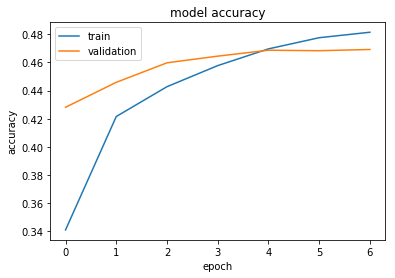

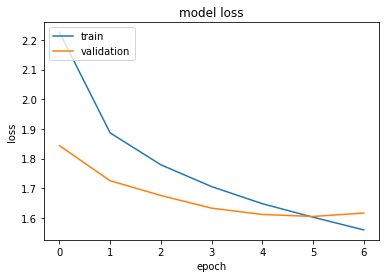

In [0]:
print(history.history.keys())
# Plot of accuracy in each epoch
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Plot of loss in each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Test set

In [0]:
loss, acc = model.evaluate(x_test,y_test)
print("Test set accuracy: ",acc)
print("Test set loss: ", loss)

5699/5699 [==============================] - 25s 4ms/step
Test set accuracy:  0.46359010353216396
Test set loss:  1.6109336463165485
